In [1]:
%matplotlib inline
#! switch_R 3.3
%load_ext rpy2.ipython

In [2]:
from __future__ import division
from copy import deepcopy
import math
import numpy as np
import pandas as pd
import pygam
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from pyspan import cross_validation as cv
from pyspan.ratings_task.analysis import freq_df, n_utterances, signal_df, SparseLR
from pyspan.synonyms.data import *
words_original = deepcopy(words)
words = words.loc[words.index != 7]
from pyspan.utils import *
from pyspan.valence import get_valence
signals = pickle.load(open(paths["metrics_dir"] + "signals-unigrams", 
                           "rb"))

/Users/sabinasloman/git/talking-politics/pyspan/config.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_i

In [3]:
data = pd.read_csv("responses.csv")
# After excluding fear vs. terror, these are the indices we're using
ixs = range(7) + range(8,26)

data.rename(columns = dict(zip(map(str, ixs), ixs)), inplace = True)
pair_cols = map(lambda i: "pair{}".format(i), ixs)

# Participants

In [4]:
# n Democrats, n Republicans, n Independents
len(data.loc[data.party == "Democrat"]), len(data.loc[data.party == "Republican"]), \
len(data.loc[~(data.party.isin(["Democrat","Republican"]))])

(77, 45, 52)

In [5]:
# Mean age and standard error of the mean
print np.mean(data.age[~np.isnan(data.age)]), stats.sem(data.age[~np.isnan(data.age)])
# n identifying as male/female
print len(data.loc[data.gender == "Male"]), len(data.loc[data.gender == "Female"])
# % voted
print np.mean(data.voted)

40.35057471264368 0.8672733959927182
88 85
0.847953216374269


# Results

In [6]:
dmask = np.ma.masked_where(data[pair_cols].isin(words["D"].values), data[ixs])
ddat = dmask.data[dmask.mask]
rmask = np.ma.masked_where(data[pair_cols].isin(words["R"].values), data[ixs])
rdat = rmask.data[rmask.mask]

Mean participant rating on the Democratic and Republican items (add 1 to obtain the numbers reported in the paper, as those are described on a 1--6 scale, while these are on a 0--5 scale).

In [7]:
dmu = np.mean(ddat[~np.isnan(ddat)])
rmu = np.mean(rdat[~np.isnan(rdat)])
dmu, rmu

(2.4944802207911683, 2.6966343937298296)

Perform one- and two-sample $t$-tests, using the clustered standard errors function provided by Arai (2011).

In [8]:
%%R
source("../clmclx.R")

One-sample test (judgments of the Democratic words).

In [9]:
ixnd, ixkd = np.where(dmask.mask)

In [10]:
%%R -i ddat,ixnd,ixkd
yd <- c(t(ddat)) - 2.5
ixnd <- ixnd[which(!is.na(yd))]
ixkd <- ixkd[which(!is.na(yd))]
fit <- lm(yd ~ 1)
print(fit$df.residual)
res <- mclx(fit, 1, ixnd, ixkd)
se <- res[1,2]
t <- res[1,3]
p <- res[1,4] / 2
print(paste(se, t, p))

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: zoo

  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘zoo’


  warnings.warn(x, RRuntimeWarning)
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


  warnings.warn(x, RRuntimeWarning)


[1] 2173
[1] "0.101977905103188 -0.0541272072930538 0.478419395664199"


One-sample test (judgments of the Republican words).

In [11]:
ixnr, ixkr = np.where(rmask.mask)

In [12]:
%%R -i rdat,ixnr,ixkr
yr <- c(t(rdat)) - 2.5
ixnr <- ixnr[which(!is.na(yr))]
ixkr <- ixkr[which(!is.na(yr))]
fit <- lm(yr ~ 1)
print(fit$df.residual)
res <- mclx(fit, 1, ixnr, ixkr)
se <- res[1,2]
t <- res[1,3]
p <- res[1,4] / 2
print(paste(se, t, p))

[1] 2168
[1] "0.122431205313992 1.60608068200859 0.054200907431661"


Two-sample test (testing the difference in means).

In [13]:
ixn = np.append(ixnd, ixnr)
ixk = np.append(ixkd, ixkr+25)

In [14]:
%%R -i ixn,ixk
y <- c(yd, yr)
ixn <- ixn[which(!is.na(y))]
ixk <- ixk[which(!is.na(y))]
groups <- c(rep(0, length(yd)), rep(1, length(yr)))
fit <- lm(y ~ groups)
print(fit$df.residual)
res <- mclx(fit, 1, ixn, ixk)
se <- res[2,2]
t <- res[2,3]
p <- res[2,4] / 2
print(paste(se, t, p))

[1] 4341
[1] "0.156445818036782 1.29216731693739 0.0981839947131734"


## Figure

Run `figures/figures_2_4.py` to obtain Figure 4.

In [15]:
def word_dat(word):
    logodds = signals.loc[word].rmetric
    mask = np.ma.masked_where(data[pair_cols] == word, data[ixs])
    dat = mask.data[mask.mask]
    judgments = dat[~np.isnan(dat)]
    return logodds, judgments

In [16]:
def word_dstats(word):
    logodds, judgments = word_dat(word)
    return logodds, np.mean(judgments), stats.sem(judgments)

In [17]:
items = np.ravel(words[["D","R"]].values)

In [18]:
wstats = np.array([ word_dstats(word) for word in items ])
wstats = np.concatenate((items[:,None],wstats),axis=1)
wstats = pd.DataFrame(wstats, columns=["word","logodds","mean","se"])
wstats.to_csv("figure.csv")

## Effect size

Using the formula from [Rouder et al. (2012)](http://pcl.missouri.edu/sites/default/files/Rouder.JMP_.2012.pdf) and explained in [Jake Westfall's blog post](http://jakewestfall.org/blog/index.php/2016/03/25/five-different-cohens-d-statistics-for-within-subject-designs/).

In [19]:
%%R -i ixn,ixk
library("lme4")
mod <- lmer(y ~ groups + (groups|ixn) + (1|ixk))
delta <- summary(mod)$coefficients[2,1]
sig <- sigma(mod)
delta / sig

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)


[1] 0.1570943


## Item-level analyses

Number of words correctly classified.

In [20]:
def calc_accuracy(word):
    logodds, judgments = word_dat(word)
    polarity = logodds > 0
    return len(judgments[judgments > 2.5 if polarity else judgments < 2.5]), len(judgments)
v_calc_accuracy = np.vectorize(calc_accuracy)

In [21]:
p, n = v_calc_accuracy(items)
p = p / n

In [22]:
(p > .5).sum(), (p[::2] > .5).sum(), (p[1::2] > .5).sum()

(29, 16, 13)

In [23]:
np.mean(p), stats.sem(p)

(0.5329562964338697, 0.027850205632423974)

In [24]:
t, p_ = stats.ttest_1samp(p, .5)
t, p_ / 2, len(p)-1

(1.1833412244360966, 0.12119169328053442, 49)

Restrict to Democratic words.

In [25]:
p, n = v_calc_accuracy(items[::2])
p = p / n
np.mean(p), stats.sem(p)

(0.5206174752883768, 0.03669962445700353)

Restrict to Republican words.

In [26]:
p, n = v_calc_accuracy(items[1::2])
p = p / n
np.mean(p), stats.sem(p)

(0.5452951175793627, 0.04251614203645201)

Mann-Whitney U test

For each word, compute the mean of the judgments across subjects, and perform a Mann-Whitney U test to determine whether the Republican words are as likely to have a higher rank than Democratic words as to have a lower rank.

In [27]:
def compute_mean_judgment(word):
    mask = np.ma.masked_where(data[pair_cols] == word, data[ixs])
    dat = mask.data[mask.mask]
    return np.mean(dat[~np.isnan(dat)])
vf = np.vectorize(compute_mean_judgment)
dmeans = vf(words["D"])
rmeans = vf(words["R"])
stats.mannwhitneyu(dmeans, rmeans, alternative = "less")

MannwhitneyuResult(statistic=256.0, pvalue=0.1386157438086561)

### Supporting Information 1

In [28]:
def item_level_summary(word):
    mask_ = np.ma.masked_where(data[pair_cols] == word, data[ixs])
    x = mask_.data[mask_.mask]
    x = x[~np.isnan(x)]
    return np.array([np.mean(x), stats.sem(x)])
v_item_level_summary = np.vectorize(item_level_summary,
                                    signature = "()->(n)")

dstats = v_item_level_summary(words["D"].values)
words["D. mean"] = dstats[:,0] + 1
words["D. SEM"] = dstats[:,1]

rstats = v_item_level_summary(words["R"].values)
words["R. mean"] = rstats[:,0] + 1
words["R. SEM"] = rstats[:,1]

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/ipykernel_la

In [29]:
def item_level_ttest(dword, rword):
    dmask_ = np.ma.masked_where(data[pair_cols] == dword, data[ixs])
    dx = dmask_.data[dmask_.mask]
    dx = dx[~np.isnan(dx)]
    rmask_ = np.ma.masked_where(data[pair_cols] == rword, data[ixs])
    rx = rmask_.data[rmask_.mask]
    rx = rx[~np.isnan(rx)]
    return sms.ttest_ind(dx, rx, alternative = "smaller", usevar = "unequal")[1]
v_item_level_ttest = np.vectorize(item_level_ttest)

In [30]:
pvals = v_item_level_ttest(words["D"], words["R"])
words["p"] = pvals
words.to_csv("S2_File.csv")

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


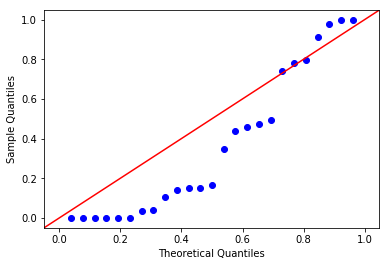

In [31]:
sm.qqplot(pvals, stats.uniform, line = "45")
plt.savefig("S2_Fig")

In [32]:
stats.kstest(pvals, stats.uniform.cdf, alternative = "greater")

KstestResult(statistic=0.3546651761069758, pvalue=0.00127765489584172)

## Participant-level analyses

Accuracies

In [33]:
def participant_accuracy(i):
    djudgments = dmask.data[i,dmask.mask[i,:]]
    djudgments = djudgments[~np.isnan(djudgments)]
    rjudgments = rmask.data[i,rmask.mask[i,:]]
    rjudgments = rjudgments[~np.isnan(rjudgments)]
    dcorrect = djudgments < 2.5
    rcorrect = rjudgments > 2.5
    return (dcorrect.sum() + rcorrect.sum()) / (len(dcorrect) + len(rcorrect))
    
participant_accuracy = np.vectorize(participant_accuracy)

(0.5348575712143928, 0.0073646980404592334)

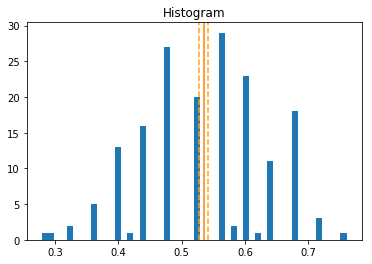

In [34]:
paccs = participant_accuracy(np.arange(len(data)))
hist, mu, se = histogram(paccs)
mu, se

In [35]:
t, p = stats.ttest_1samp(paccs, .5)
t, p / 2, len(paccs) - 1, len([ pacc for pacc in paccs if pacc > .5 ])

(4.73306183402181, 2.289872097652954e-06, 173, 108)

Discriminabilities

In [36]:
def participant_diff(i):
    djudgments = dmask.data[i,dmask.mask[i,:]]
    djudgments = djudgments[~np.isnan(djudgments)]
    rjudgments = rmask.data[i,rmask.mask[i,:]]
    rjudgments = rjudgments[~np.isnan(rjudgments)]
    return cohensd(rjudgments, djudgments)
    
participant_diff = np.vectorize(participant_diff)

(0.1573932224670715, 0.03179973113791762)

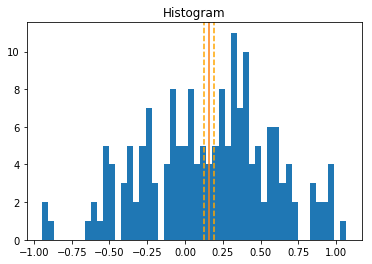

In [37]:
pdiffs = participant_diff(np.arange(len(data)))
hist, mu, se = histogram(pdiffs)
mu, se

In [38]:
t, p = stats.ttest_1samp(pdiffs, 0)
t, p / 2, len(pdiffs) - 1

(4.949514251691194, 8.776095043328314e-07, 173)

# Discussion

Magnitude of the $logodds_R$ value on the Republican and Democratic items, respectively.

In [39]:
np.mean(signal_df.loc[words.R].rmetric), np.mean(signal_df.loc[words.D].rmetric)

(0.3831152069619121, -0.4243133415757932)

# Appendix D

Binarize judgments into "more likely that the word was spoken by a Republican" ("REPUBLICAN"; rating >= 3) and "more likely that the word was spoken by a Democrat" (rating < 3).

Estimate the following logistic regression model (with participant-level effects): REPUBLICAN ~ Dummy indicating whether the word is Republican + Valence of word + Participant's party identity + Valence of word * Participant's party identity

In [40]:
lr_data = data.copy()
lr_data = lr_data.loc[lr_data.party.isin([ "Democrat", "Republican" ])]

n = len(lr_data)
# Add dummy columns for participants
for i in range(1, n):
    ids = np.zeros(n)
    ids[i] = 1
    lr_data["participant{}".format(i)] = ids

In [41]:
Y_full = np.ravel(lr_data[ixs])
Y = Y_full > 2.5
# (n ps * n choices, 5 + (n ps - 1) + (n items - 1))
X = np.full((n * len(ixs), 5 + (n - 1) + (2*len(ixs) - 1)), np.nan)
# Dummy indicating whether the word is Republican
vf = np.vectorize(lambda word: int(word in words["R"].values))
X[:,0] = vf(np.ravel(lr_data[pair_cols]))
# Valence of word
vf = np.vectorize(lambda word: get_valence(word)[0]-5)
X[:,1] = vf(np.ravel(lr_data[pair_cols])) - 5
# Participant's political identity
vf = np.vectorize(lambda pid: int(pid == "Republican"))
pids = np.repeat(vf(lr_data.party), len(ixs))
pids[pids == 0] = -1
X[:,2] = pids
# Valence of word * Participant's party identity
X[:,3] = X[:,1] * np.array([ x if x != 0 else -1 for x in X[:,2] ])

# Add participant dummies
for i in range(4, 4 + n - 1):
    X[:,i] = np.repeat(lr_data["participant{}".format(i-3)], len(ixs))
    
# Add item dummies
list_of_words = np.ravel(words[["D","R"]].values)
for i in range(1,2*len(ixs)):
    vf = np.vectorize(lambda word: int(list_of_words[i] == word))
    X[:,4+n-1+i-1] = vf(np.ravel(lr_data[pair_cols]))

# The log odds that the word was said by a Republican
vf = np.vectorize(lambda word: signals.loc[word]["rmetric"])
X[:,-1] = vf(np.ravel(lr_data[pair_cols]))

Y = Y[~np.isnan(Y_full)]
X = X[~np.isnan(Y_full)]
Y_full = Y_full[~np.isnan(Y_full)]
X = X[~np.isnan(Y)]
Y_full = Y_full[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]
Y = Y[~np.isnan(X).any(axis = 1)]
Y_full = Y_full[~np.isnan(X).any(axis = 1)]
X = X[~np.isnan(X).any(axis = 1),:]

# Since we don't have valence data for some of the words, their observations will be deleted and their indicator columns will
# just be clutter (and cause problems with model estimation)
colixs = np.arange(0,X.shape[1])
to_del = np.where(np.apply_along_axis(lambda x: np.all(x == 0), 0, X[:,4+n-1:-1]))[0] + 4+n-1
colixs = [ colix for colix in colixs if colix not in to_del ]
X = X[:,colixs]

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


Table 1 column 1: Binary DV; binarized $logodds_R$ variable.

In [42]:
# Ensure the matrix is of full rank
assert X[:,:4+n-1].shape[1] == np.linalg.matrix_rank(X[:,:4+n-1])
# Estimate the model
logit = SparseLR(Y, X[:,:4+n-1]); logit.coef[:4], len(Y), logit.auc

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


(array([ 0.11477082, -0.11866294,  0.65120808,  0.08750617]),
 2498,
 0.6479050194214306)

In [43]:
# Include item-level effects, just as a robustness check
logit = SparseLR(Y, X[:,:-1]); logit.coef[:4], len(Y), logit.auc

(array([ 0.43183715, -0.16278784,  1.03169412,  0.16737174]),
 2498,
 0.770323861577001)

Table 1 column 2: Binary DV; continuous $logodds_R$ variable.

In [44]:
# Ensure the matrix is of full rank
assert X[:,np.append(-1, np.arange(1, 4+n-1))].shape[1] == np.linalg.matrix_rank(X[:,np.append(-1, np.arange(1, 4+n-1))])
# Estimate the model
logit = SparseLR(Y, X[:,np.append(-1, np.arange(1, 4+n-1))]); logit.coef[:4], logit.auc

(array([ 0.2388105 , -0.10951937,  0.65253135,  0.08751662]),
 0.6533558500043302)

In [45]:
# Include item-level effects, just as a robustness check
logit = SparseLR(Y, X[:,np.append(-1, np.arange(1, X.shape[1]-1))]); logit.coef[:4], len(Y), logit.auc

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(array([ 0.38462828, -0.19172288,  1.03237277,  0.16753869]),
 2498,
 0.7694052327203795)

Generalized additive model.

In [46]:
X_ = deepcopy(X[:,:4+n-1])
# Run using the log odds that the word was said by a Republican rather
# than the binary indicator
X_[:,0] = X[:,-1]

In [47]:
logistic_gam = pygam.LogisticGAM(pygam.terms.TermList(*[pygam.s(0), pygam.s(1), 
                                 pygam.f(2), pygam.s(3)] + 
                                 [pygam.f(i) for i in range(4, X_.shape[1])]))
logistic_gam.fit(X_, Y)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + s(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + f(16) + f(17) + f(18) + f(19) + f(20) + f(21) + f(22) + f(23) + f(24) + f(25) + f(26) + f(27) + f(28) + f(29) + f(30) + f(31) + f(32) + f(33) + f(34) + f(35) + f(36) + f(37) + f(38) + f(39) + f(40) + f(41) + f(42) + f(43) + f(44) + f(45) + f(46) + f(47) + f(48) + f(49) + f(50) + f(51) + f(52) + f(53) + f(54) + f(55) + f(56) + f(57) + f(58) + f(59) + f(60) + f(61) + f(62) + f(63) + f(64) + f(65) + f(66) + f(67) + f(68) + f(69) + f(70) + f(71) + f(72) + f(73) + f(74) + f(75) + f(76) + f(77) + f(78) + f(79) + f(80) + f(81) + f(82) + f(83) + f(84) + f(85) + f(86) + f(87) + f(88) + f(89) + f(90) + f(91) + f(92) + f(93) + f(94) + f(95) + f(96) + f(97) + f(98) + f(99) + f(100) + f(101) + f(102) + f(103) + f(104) + f(105) + f(106) + f(107) + f(108) + f(109) + f(110) + f(111)

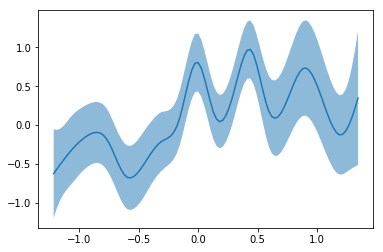

In [48]:
plot_prf(logistic_gam, 0, logit.coef[0])

Table 1 column 3: Ordinal DV; binary $logodds_R$ variable.

In [49]:
X_ = X[:,:4+n-1]
lm = sm.OLS(Y_full, sm.add_constant(X_))
res = lm.fit_regularized()
res.params[1:5]

array([ 0.23225837, -0.1240314 ,  0.18140637,  0.11781563])

In [50]:
# Adjusted R squared
# https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2
ssr = ( (Y_full - res.predict(sm.add_constant(X_)))**2 ).sum()
ssr /= X_.shape[0] - X_.shape[1] - 1
sst = np.var(Y_full)*len(Y_full)
sst /= len(Y_full) - 1
1 - ssr / sst

0.07742260171318271

In [51]:
# Include item-level effects as a robustness check
X_ = X[:,:-1]
lm = sm.OLS(Y_full, sm.add_constant(X_))
res = lm.fit_regularized()
res.params[1:5]

array([ 0.16178379, -0.00337185,  0.25485247,  0.11677368])

Table 1 column 4: Ordinal DV; continuous $logodds_R$ variable.

In [52]:
X_ = X[:,np.append(-1, np.arange(1, 4+n-1))]
lm = sm.OLS(Y_full, sm.add_constant(X_))
res = lm.fit_regularized()
res.params[1:5]

array([ 0.22662885, -0.11406856,  0.20205513,  0.11756506])

In [53]:
# Adjusted R squared
# https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2
ssr = ( (Y_full - res.predict(sm.add_constant(X_)))**2 ).sum()
ssr /= X_.shape[0] - X_.shape[1] - 1
sst = np.var(Y_full)*len(Y_full)
sst /= len(Y_full) - 1
1 - ssr / sst

0.07908467524778517

In [54]:
# Include item-level effects as a robustness check
X_ = X[:,np.append(-1, np.arange(1, X.shape[1]-1))]
lm = sm.OLS(Y_full, sm.add_constant(X_))
res = lm.fit_regularized()
res.params[1:5]

array([ 0.11952902, -0.01572811,  0.25871046,  0.1167581 ])

Generalized additive model

In [55]:
X_ = X[:,:4+n-1]
linear_gam = pygam.LinearGAM(pygam.terms.TermList(*[pygam.s(0), pygam.s(1), 
                             pygam.f(2), pygam.s(3)] + 
                             [pygam.f(i) for i in range(4, X_.shape[1])]))
linear_gam.fit(X_, Y_full)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + f(2) + s(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + f(16) + f(17) + f(18) + f(19) + f(20) + f(21) + f(22) + f(23) + f(24) + f(25) + f(26) + f(27) + f(28) + f(29) + f(30) + f(31) + f(32) + f(33) + f(34) + f(35) + f(36) + f(37) + f(38) + f(39) + f(40) + f(41) + f(42) + f(43) + f(44) + f(45) + f(46) + f(47) + f(48) + f(49) + f(50) + f(51) + f(52) + f(53) + f(54) + f(55) + f(56) + f(57) + f(58) + f(59) + f(60) + f(61) + f(62) + f(63) + f(64) + f(65) + f(66) + f(67) + f(68) + f(69) + f(70) + f(71) + f(72) + f(73) + f(74) + f(75) + f(76) + f(77) + f(78) + f(79) + f(80) + f(81) + f(82) + f(83) + f(84) + f(85) + f(86) + f(87) + f(88) + f(89) + f(90) + f(91) + f(92) + f(93) + f(94) + f(95) + f(96) + f(97) + f(98) + f(99) + f(100) + f(101) + f(102) + f(103) + f(104) + f(105) + f(106) + f(107) + f(108) + f(109) + f(110) + f(111) +

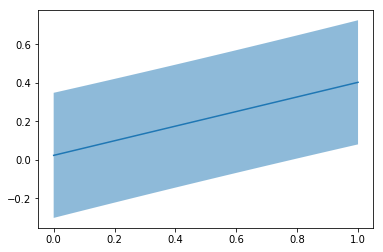

In [56]:
plot_prf(linear_gam, 0, res.params[1])

# Appendix E

Is there a difference in the discriminability of Democrats and Republicans?

In [57]:
ddiffs = participant_diff(np.arange(len(data))[data.party == "Democrat"])
rdiffs = participant_diff(np.arange(len(data))[data.party == "Republican"])
print np.mean(rdiffs) - np.mean(ddiffs)
cm = sms.CompareMeans(sms.DescrStatsW(rdiffs), sms.DescrStatsW(ddiffs))
cm.ttest_ind(usevar="unequal")

-0.009113493024315439


(-0.11037674105419748, 0.9123805369639919, 81.92708472834495)

$accurate \sim logodds + log(P) + party\_id + valence + party\_id \times valence \times sign(word) + party\_identity + party\_id \times party\_identity + political\_engagement + party\_id \times political\_engagement + \ldots{}$

In [58]:
n_vars = 9

Y_full = np.ravel(lr_data[ixs])
Y = Y_full > 2.5
X = np.full((n * len(ixs), n_vars + n - 1 +(2*len(ixs) - 1)), np.nan)
# The log odds that the word was said by a Republican
vf = np.vectorize(lambda word: signals.loc[word]["rmetric"])
s = vf(np.ravel(lr_data[pair_cols]))
X[:,0] = np.abs(s)
# The log probability of hearing the word
vf = np.vectorize(lambda word: math.log(sum(freq_df.loc[(word,["dmetric","rmetric"])].values) / n_utterances, 2))
X[:,1] = vf(np.ravel(lr_data[pair_cols]))
# Participant's political identity
vf = np.vectorize(lambda pid: 1 if pid == "Republican" else -1 if pid == "Democrat" else 0
                 )
pids = np.repeat(vf(lr_data.party), len(ixs))
X[:,2] = pids
# Valence of word
vf = np.vectorize(lambda word: get_valence(word)[0]-5)
X[:,3] = vf(np.ravel(lr_data[pair_cols]))
# Valence of word * Participant's party identity * Word is Republican
X[:,4] = pids * X[:,3] * np.sign(s) 
# Party identity
X[:,5] = np.repeat(lr_data.party_identity, len(ixs))
# Party affiliation x party identity
X[:,6] = pids * X[:,5]
# Political engagement
X[:,7] = np.repeat(lr_data.political_engagement, len(ixs))
# Party affiliation x political engagement
X[:,8] = pids * X[:,7]
# Participant IDs
for i in range(n_vars, n_vars + n - 1):
    X[:,i] = np.repeat(lr_data["participant{}".format(i-n_vars+1)], len(ixs))

# Add item dummies
list_of_words = np.ravel(words[["D","R"]].values)
for i in range(1,2*len(ixs)):
    vf = np.vectorize(lambda word: int(list_of_words[i] == word))
    X[:,n_vars+n-1+i-1] = vf(np.ravel(lr_data[pair_cols]))
    
vf = np.vectorize(lambda word: signals.loc[word]["rmetric"] > 0)
polarity = vf(np.ravel(lr_data[pair_cols]))
Y = (Y & polarity) | (~Y & ~polarity)

Y = Y[~np.isnan(Y_full)]
X = X[~np.isnan(Y_full)]
Y_full = Y_full[~np.isnan(Y_full)]
X = X[~np.isnan(Y)]
Y_full = Y_full[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]
Y = Y[~np.isnan(X).any(axis = 1)]
Y_full = Y_full[~np.isnan(X).any(axis = 1)]
X = X[~np.isnan(X).any(axis = 1),:]

# Since we don't have valence data for some of the words, their observations will be deleted and their indicator columns will
# just be clutter (and cause problems with model estimation)
colixs = np.arange(0,X.shape[1])
to_del = np.where(np.apply_along_axis(lambda x: np.all(x == 0), 0, X[:,n_vars+n-1:-1]))[0] + n_vars+n-1
colixs = [ colix for colix in colixs if colix not in to_del ]
X = X[:,colixs]

X = stats.mstats.zscore(X)

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/politics-test-bed/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [59]:
# Estimate a model without fixed effects, for consistency with the analysis for Study 1
logit = SparseLR(Y, X[:,:n_vars]); logit.coef, logit.n, logit.auc

(array([ 0.08715752, -0.32706123,  0.07089629, -0.18965005,  0.39270759,
         0.02341418, -0.01875962,  0.05689167, -0.01411482]),
 2498,
 0.648881414025749)